<a href="https://colab.research.google.com/github/aditya4196/Melanoma_skin_lesion_segmentation/blob/main/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras import callbacks
import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Imported the important libraries


In [ ]:
import sys

!git clone https://github.com/rezazad68/BCDU-Net.git
sys.path.append("/content/BCDU-Net/Skin Lesion Segmentation")

Cloning into 'BCDU-Net'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 577 (delta 21), reused 37 (delta 10), pack-reused 527
Receiving objects: 100% (577/577), 13.41 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (278/278), done.


In [ ]:


import numpy as np
import scipy.io as sio
from scipy import misc
import glob
from __future__ import division
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
from __future__ import division
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD
from keras.optimizers import *
from keras.layers import *
from keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


fatal: destination path 'BCDU-Net' already exists and is not an empty directory.


In [ ]:
# Parameters
height = 256
width  = 256
channels = 3

unzipped the input images with the binary masks (ground truth images)

In [ ]:
!unzip '/content/drive/MyDrive/NN_Project2/Data/RCNNDataset/ISIC-2017_Training_Part1_GroundTruth.zip' -d '/content/dataset/'

In [ ]:
!unzip '/content/drive/MyDrive/NN_Project2/Data/RCNNDataset/ISIC-2017_Training_Data.zip' -d '/content/dataset/'

In [ ]:
DATASET_PATH = os.path.abspath("/content/dataset")
IMAGES_PATH = os.path.sep.join([DATASET_PATH, "ISIC-2017_Training_Data"])
MASKS_PATH = os.path.sep.join([DATASET_PATH, "ISIC-2017_Training_Part1_GroundTruth"])

dataset_path_str = "/content/dataset/"

Some cleaning of unwanted images

In [ ]:
import os
import glob
# my all files starts with "frame" and ends with ".jpg"
fileList = glob.glob('/content/dataset/ISIC-2017_Training_Data/*.png')
print("Number of files: ",len(fileList))

for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

Number of files:  0


In [ ]:
input_list = glob.glob(IMAGES_PATH + '/*.jpg')

In [ ]:
mask_list = glob.glob(MASKS_PATH + '/*.png')

In [ ]:
print("imglen",len(input_list))
print("msklen",len(mask_list))

imglen 2000
msklen 2000


In [ ]:
train_input    = np.zeros([2000, height, width, channels])
train_masks   = np.zeros([2000, height, width])

Converted the Images into np arrays

In [ ]:
for idx in range(len(input_list)):
    print(idx+1)
    img = cv2.imread(input_list[idx])
    resized_img = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
    resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    img = np.double(resized_img)
    train_input[idx, :,:,:] = img

    b = input_list[idx]
    a = b[0:len(dataset_path_str)]
    b = b[len(b)-16: len(b)-4]
    print(a)
    print(b)
    add = (a+ 'ISIC-2017_Training_Part1_GroundTruth/' + b +'_segmentation.png')
    img2 = cv2.imread(add)
    resized_img2 = cv2.resize(img2, (width, height), interpolation=cv2.INTER_LINEAR)
    resized_img2 = cv2.cvtColor(resized_img2, cv2.COLOR_BGR2GRAY)
    img2 = np.double(resized_img2)
    train_masks[idx, :,:] = img2

Loaded them in npy files as checkpoint

In [ ]:
Train_img      = train_input[0:1400,:,:,:]
Validation_img = train_input[1400:1800,:,:,:]
Test_img       = train_input[1800:2000,:,:,:]

Train_mask      = train_masks[0:1400,:,:]
Validation_mask = train_masks[1400:1800,:,:]
Test_mask       = train_masks[1800:2000,:,:]


np.save('/content/drive/MyDrive/NN_Project2/data_train', Train_img)
np.save('/content/drive/MyDrive/NN_Project2/data_test' , Test_img)
np.save('/content/drive/MyDrive/NN_Project2/data_val'  , Validation_img)

np.save('/content/drive/MyDrive/NN_Project2/mask_train', Train_mask)
np.save('/content/drive/MyDrive/NN_Project2/mask_test' , Test_mask)
np.save('/content/drive/MyDrive/NN_Project2/mask_val'  , Validation_mask)

In [ ]:
!ls /content/

dataset  drive	Mask_RCNN  mask_rcnn_coco.h5  sample_data


Normalized the images (np arrays)

In [ ]:
def dataset_normalized(imgs):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized

In [ ]:
tr_data    = np.load('/content/drive/MyDrive/NN_Project2/data_train.npy')
te_data    = np.load('/content/drive/MyDrive/NN_Project2/data_test.npy')
val_data   = np.load('/content/drive/MyDrive/NN_Project2/data_val.npy')

tr_mask    = np.load('/content/drive/MyDrive/NN_Project2/mask_train.npy')
te_mask    = np.load('/content/drive/MyDrive/NN_Project2/mask_test.npy')
val_mask   = np.load('/content/drive/MyDrive/NN_Project2/mask_val.npy')

tr_mask    = np.expand_dims(tr_mask, axis=3)
te_mask    = np.expand_dims(te_mask, axis=3)
val_mask   = np.expand_dims(val_mask, axis=3)

print('ISIC18 Dataset loaded')

tr_data   = dataset_normalized(tr_data)
te_data   = dataset_normalized(te_data)
val_data  = dataset_normalized(val_data)

tr_mask   = tr_mask /255.
te_mask   = te_mask /255.
val_mask  = val_mask /255.

ISIC18 Dataset loaded


The Bi-Directional ConvLSTM Unet algorithm

In [ ]:
def BCDU_net_D3(input_size = (256,256,1)):
    N = input_size[0]
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)
    conv4_2 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)
    conv4_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)

    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 256))(up6)
    merge6  = concatenate([x1,x2], axis = 1)
    merge6 = ConvLSTM2D(filters = 128, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge6)

    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 128))(up7)
    merge7  = concatenate([x1,x2], axis = 1)
    merge7 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)

    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N, N, 64))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 64))(up8)
    merge8  = concatenate([x1,x2], axis = 1)
    merge8 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)

    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs = inputs, outputs = conv9)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
model = BCDU_net_D3(input_size = (256,256,3))
model.summary()

print('Training')
batch_size = 8
nb_epoch = 10

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training and Saving the model as a checkpoint

We performed three iterations of training, each of 10 epochs and saved each as a checkpoint


In [ ]:
modelcheckpoint = ModelCheckpoint('/content/drive/MyDrive/NN_Project2/weight_isic_model1', save_best_only=True, monitor='val_loss', mode='min')
reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=2, epsilon=1e-4, mode='min')
history = model.fit(tr_data,tr_mask,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_data=(val_data, val_mask), callbacks=[modelcheckpoint, reduction] )

Epoch 1/10
175/175 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.8042

175/175 [==============================] - 273s 1s/step - loss: 0.3893 - accuracy: 0.8042 - val_loss: 0.4042 - val_accuracy: 0.8057 - lr: 1.0000e-04
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.8947

175/175 [==============================] - 243s 1s/step - loss: 0.2849 - accuracy: 0.8947 - val_loss: 0.2912 - val_accuracy: 0.9276 - lr: 1.0000e-04
Epoch 3/10
175/175 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.9183

175/175 [==============================] - 242s 1s/step - loss: 0.2535 - accuracy: 0.9183 - val_loss: 0.2419 - val_accuracy: 0.9354 - lr: 1.0000e-04
Epoch 4/10
175/175 [==============================] - 230s 1s/step - loss: 0.2437 - accuracy: 0.9260 - val_loss: 0.3137 - val_accuracy: 0.9046 - lr: 1.0000e-04
Epoch 5/10
175/175 [==============================] - 230s 1s/step - loss: 0.2367 - accuracy: 0.9294 - val_loss: 0.2959 - val_accuracy: 0.9128 - lr: 1.0000e-04
Epoch 6/10
175/175 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9295

175/175 [==============================] - 241s 1s/step - loss: 0.2353 - accuracy: 0.9295 - val_loss: 0.2417 - val_accuracy: 0.9402 - lr: 1.0000e-04
Epoch 7/10
175/175 [==============================] - 229s 1s/step - loss: 0.2299 - accuracy: 0.9332 - val_loss: 0.2738 - val_accuracy: 0.9235 - lr: 1.0000e-04
Epoch 8/10
175/175 [==============================] - 229s 1s/step - loss: 0.2255 - accuracy: 0.9336 - val_loss: 0.4025 - val_accuracy: 0.8756 - lr: 1.0000e-04
Epoch 9/10
175/175 [==============================] - 229s 1s/step - loss: 0.2213 - accuracy: 0.9365 - val_loss: 0.2434 - val_accuracy: 0.9293 - lr: 1.0000e-04
Epoch 10/10
175/175 [==============================] - 229s 1s/step - loss: 0.2169 - accuracy: 0.9389 - val_loss: 0.2477 - val_accuracy: 0.9409 - lr: 1.0000e-04


In [ ]:
model.load_weights('/content/drive/MyDrive/NN_Project2/weight_isic_model3')

In [ ]:
mcp_save = ModelCheckpoint('/content/drive/MyDrive/NN_Project2/weight_isic_model3', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=2, epsilon=1e-4, mode='min')
history = model.fit(tr_data,tr_mask,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_data=(val_data, val_mask), callbacks=[mcp_save, reduce_lr_loss] )

Epoch 1/10
175/175 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9421

175/175 [==============================] - 266s 1s/step - loss: 0.2065 - accuracy: 0.9421 - val_loss: 0.2245 - val_accuracy: 0.9311 - lr: 1.0000e-04
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.2117 - accuracy: 0.9400

175/175 [==============================] - 234s 1s/step - loss: 0.2117 - accuracy: 0.9400 - val_loss: 0.2133 - val_accuracy: 0.9354 - lr: 1.0000e-04
Epoch 3/10
175/175 [==============================] - 220s 1s/step - loss: 0.2045 - accuracy: 0.9433 - val_loss: 0.2340 - val_accuracy: 0.9186 - lr: 1.0000e-04
Epoch 4/10
175/175 [==============================] - 222s 1s/step - loss: 0.1978 - accuracy: 0.9469 - val_loss: 0.2145 - val_accuracy: 0.9439 - lr: 1.0000e-04
Epoch 5/10
175/175 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.9479

175/175 [==============================] - 235s 1s/step - loss: 0.1954 - accuracy: 0.9479 - val_loss: 0.2032 - val_accuracy: 0.9516 - lr: 1.0000e-04
Epoch 6/10
175/175 [==============================] - 220s 1s/step - loss: 0.1950 - accuracy: 0.9471 - val_loss: 0.2316 - val_accuracy: 0.9361 - lr: 1.0000e-04
Epoch 7/10
175/175 [==============================] - 220s 1s/step - loss: 0.1923 - accuracy: 0.9486 - val_loss: 0.2101 - val_accuracy: 0.9465 - lr: 1.0000e-04
Epoch 8/10
175/175 [==============================] - 220s 1s/step - loss: 0.1935 - accuracy: 0.9470 - val_loss: 0.2311 - val_accuracy: 0.9394 - lr: 1.0000e-04
Epoch 9/10
175/175 [==============================] - 220s 1s/step - loss: 0.1895 - accuracy: 0.9493 - val_loss: 0.2049 - val_accuracy: 0.9489 - lr: 1.0000e-04
Epoch 10/10
175/175 [==============================] - 222s 1s/step - loss: 0.1856 - accuracy: 0.9512 - val_loss: 0.2407 - val_accuracy: 0.9156 - lr: 1.0000e-04


In [ ]:
print('Trained model saved')
with open('History', 'wb') as file_pi:
        pickle.dump(model.history, file_pi)

Trained model saved


In [ ]:
testd = np.load('/content/drive/MyDrive/NN_Project2/data_test.npy')
testm = np.load('/content/drive/MyDrive/NN_Project2/mask_test.npy')
testm = np.expand_dims(testm, axis=3)

Evaluation of the model

In [ ]:
testd  = dataset_normalized(testd)

In [ ]:
#model = BCDU_net_D3(input_size = (256,256,3))
#model.summary()
#model.load_weights('/content/drive/MyDrive/NN_Project2/weight_isic_model1')
predictions = model.predict(testd, batch_size=8, verbose=2)

25/25 - 24s - 24s/epoch - 949ms/step


In [ ]:
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

In [ ]:
y_scores = predictions.reshape(predictions.shape[0]*predictions.shape[1]*predictions.shape[2]*predictions.shape[3], 1)
print(y_scores.shape)

y_true = te_mask.reshape(te_mask.shape[0]*te_mask.shape[1]*te_mask.shape[2]*te_mask.shape[3], 1)

y_scores = np.where(y_scores>0.5, 1, 0)
y_true   = np.where(y_true>0.5, 1, 0)

output_folder = '/content/drive/MyDrive/NN_Project2/output/'



(13107200, 1)



Area under the ROC curve: 0.9027196714426009


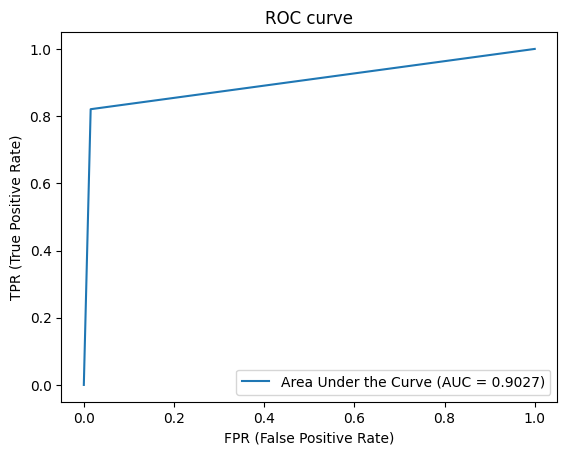

In [ ]:
#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
print ("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(output_folder+"ROC.png")




Area under Precision-Recall curve: 0.8891343786140041


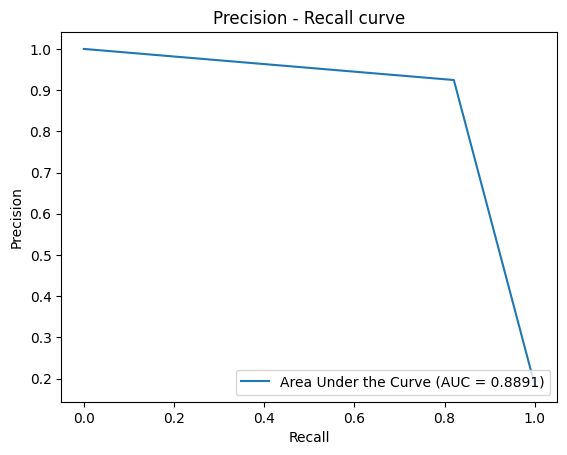

In [ ]:
#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]
recall = np.fliplr([recall])[0]
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(output_folder+"Precision_recall.png")



In [ ]:
#Confusion matrix
threshold_confusion = 0.5
print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print (confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print ("Precision: " +str(precision))

#Jaccard similarity index
jaccard_index = jaccard_score(y_true, y_pred, average = "macro")
print ("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

#Save the results
# file_perf = open(output_folder+'performances.txt', 'w')
# file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
#                 + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
#                 + "\nJaccard similarity score: " +str(jaccard_index)
#                 + "\nF1 score (F-measure): " +str(F1_score)
#                 +"\n\nConfusion matrix:"
#                 +str(confusion)
#                 +"\nACCURACY: " +str(accuracy)
#                 +"\nSENSITIVITY: " +str(sensitivity)
#                 +"\nSPECIFICITY: " +str(specificity)
#                 +"\nPRECISION: " +str(precision)
#                 )
# file_perf.close()




Confusion matrix:  Custom threshold (for positive) of 0.5
[[10524258   162178]
 [  434248  1986516]]
Global Accuracy: 0.9544963073730469
Specificity: 0.9848239394312566
Sensitivity: 0.8206153098773775
Precision: 0.9245225239145267

Jaccard similarity score: 0.8577291537905689

F1 score (F-measure): 0.8694755483035407


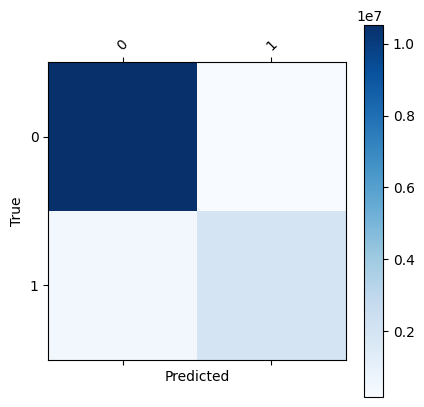

In [ ]:
import matplotlib.pyplot as plt
import itertools
cm = confusion_matrix(y_true, y_pred)
normalize = False
title = 'Confusion Matrix'

plt.matshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, range(2), rotation=45)
plt.yticks(tick_marks, range(2))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# plt.matshow(confusion, interpolation='nearest', cmap=plt.confusion.Blues)
# plt.title(title)
# plt.colorbar()
# tick_marks = np.arange(3)
# plt.xticks(tick_marks, range(3), rotation=45)
# plt.yticks(tick_marks, range(3))
# if normalize:
#     confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

# thresh = confusion.max() / 2.
# for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
#     plt.text(j, i, confusion[i, j],
#               horizontalalignment="center",
#               color="white" if confusion[i, j] > thresh else "black")

# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')

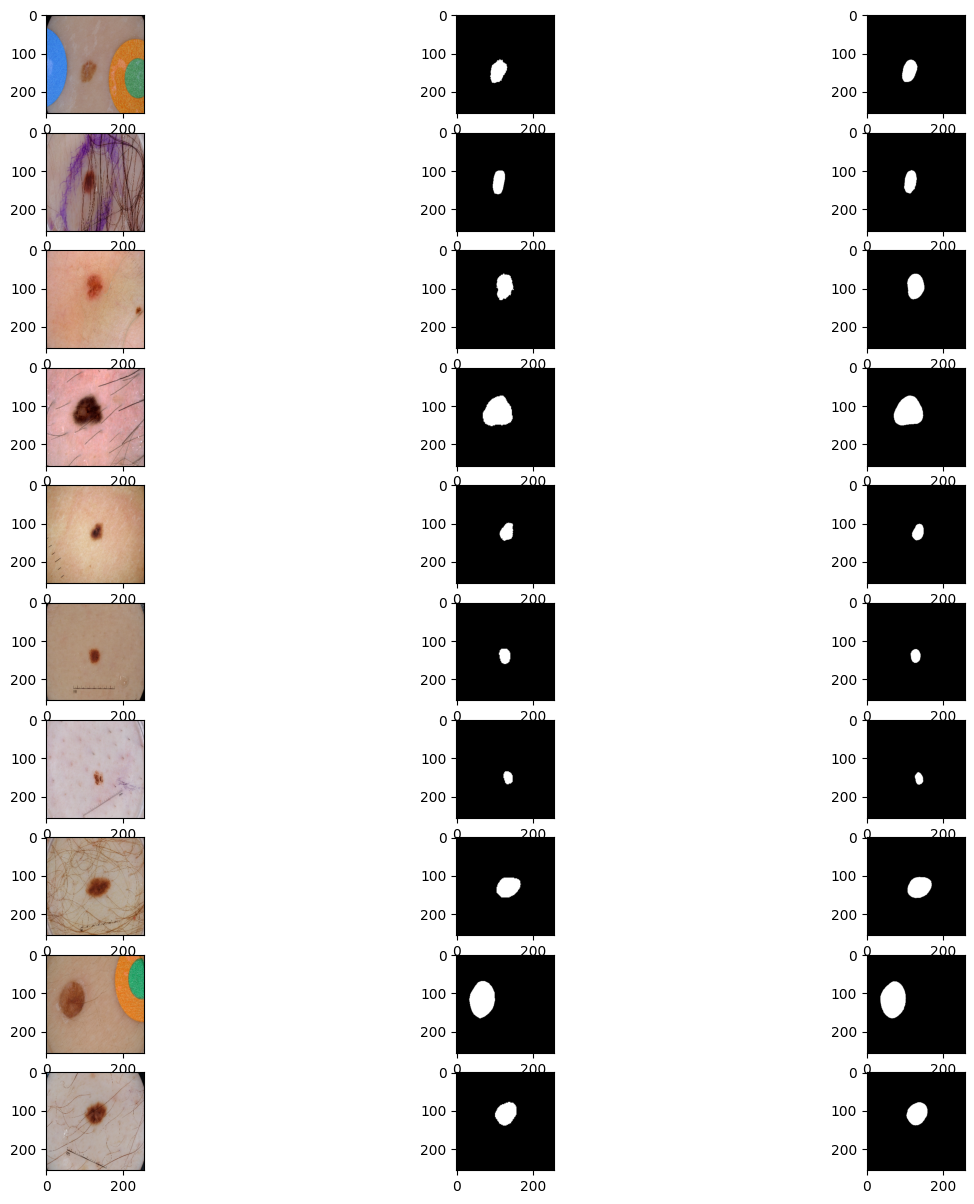

In [ ]:
#Save 10 results with error rate lower than threshold
threshold = 300
predictions = np.where(predictions>0.5, 1, 0)
te_mask     = np.where(te_mask>0.5, 1, 0)
good_prediction = np.zeros([predictions.shape[0],1], np.uint8)
id_m = 0
for idx in range(predictions.shape[0]):
    esti_sample = predictions[idx]
    true_sample = te_mask[idx]
    esti_sample = esti_sample.reshape(esti_sample.shape[0]*esti_sample.shape[1]*esti_sample.shape[2], 1)
    true_sample = true_sample.reshape(true_sample.shape[0]*true_sample.shape[1]*true_sample.shape[2], 1)
    er = 0
    for idy in range(true_sample.shape[0]):
        if esti_sample[idy] != true_sample[idy]:
           er = er +1
    if er <threshold:
       good_prediction[id_m] = idx
       id_m += 1

fig,ax = plt.subplots(10,3,figsize=[15,15])

for idx in range(10):
    ax[idx, 0].imshow(np.uint8(te_data[good_prediction[idx,0]]))
    ax[idx, 1].imshow(np.squeeze(te_mask[good_prediction[idx,0]]), cmap='gray')
    ax[idx, 2].imshow(np.squeeze(predictions[good_prediction[idx,0]]), cmap='gray')

plt.savefig(output_folder+'sample_results.png')